# Evaluation Task: Decoding quantum states through nuclear magnetic resonance

### Overview

- Nuclear Magnetic Resonance (NMR) is an experimental technique that allows for the control and measurement of nuclear spins in crystals and molecules.
- A common "recipe" for NMR is called the spin echo: the spins are aligned, let loose, and then refocused, making a sharp peak, or "echo", of the original alignment. When the spins interact with each other, the refocused echo in the magnetization $M$ can become highly distorted.
- Materials with strong electron-electron couplings show a wide variety of phenomena, from superconductivity to ferromagnetism. They also tend to enhance the nuclear spin-spin couplings, allowing NMR to act as a probe of these important systems.
- In this evaluation, you will desgin and train a model that predicts the strength and shape of interactions between the nuclear spins from simulated time-dependent magnetization curves, $M(t)$. 
- The four (4) evaluation tasks follow after an introduction to the problem and code which downloads the dataset you will use.


## A quick intro to NMR and spin echos

Although the NMR "spin echo" technique may sound complicated, the following animation created by Gavin W Morley (by way of https://en.wikipedia.org/wiki/Spin_echo) makes it much clearer!

The red arrows in this animation represents the values of nuclear spins in the material.
They all begin in the same direction (up), and then an applied magnetic field rotates them into the x-y plane (indicated by the 90$^\circ$ pulse).
A constant external magnetic field in the z-direction did not affect the spins when they were pointing "up", but now that they lie in the x-y plane they begin to precess.


Because each nuclear spin sits in a slightly different magnetic environment, each one has a slightly different response to the background z-direction magnetic field, causing some to precess in a clockwise direction and others in a counterclockwise direction.


After a fixed amount of time, $t$ in the above animation, a second magnetic pulse is applied and rotates each spin 180$^\circ$ in the x-y plane.
After this, the spins continue to move as they did before, but because of the 180$^\circ$ pulse they are now effectively precessing  "backwards" compared to the original motion!
So after an additional time $t$ passes, the variations in precession time is canceled out, causing a refocusing of the spins.

This shows up as a measurable "echo" in the average spin magnetization of the material, and can be measured in experiments.
This is an important technique because the average spin magnetization is hard to measure during an applied "pulse", but there is no external pulse during the "echo", allowing for accurate measurement of the peak value and decay shape.

Here is a typical curve for the time-dependent magnetization $M(t)$ for a spin-echo in most materials:

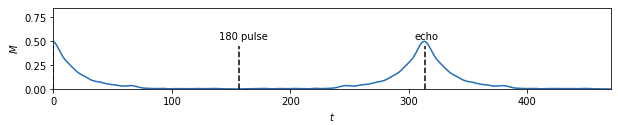

Sometimes, a more complicated curve can occur, such as:

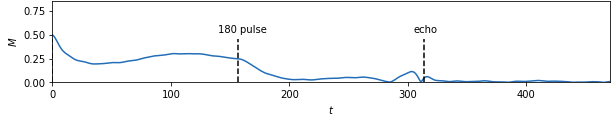

This more complicated structure has been caused by spin-spin interactions between the precessing nuclear spins. Normally, each spin precesses in a uniform way irrespective of the rest of the nuclei in the material. In this coupled case, however, the nuclear magnetization that occurs near the "echo" influences the spins' motions, modifying the shape of the observed echo.

## Note that the values of $M$ are complex numbers, and above we have just plotted the absolute value $|M|$ for convienence.

## Electronic and nuclear spins

Most materials can be classified by their electronic properties into three categories: metal, insulator, and semiconductor.
These terms are based on a semi-classical description of the electrons in a crystal.
The electrons are treated as a collection of classical particles, with energies that depend on their momentum in a way determined by the atomic structure of the crystal.

However, there are other electronic phases of matter that are truly "quantum" and cannot be described accurately with a classical analogy.
In these scenarios, complicated structures in the electron states can give rise to large electronic spin density or strong electron-electron coupling.
Because of these strong couplings between electrons, they are often hard to probe experimentally.

Luckily, electrons can interact with the nuclar spins of a material (by way of the hyperfine-interaction).
If the electron-nuclear coupling becomes strong enough (enhanced perhaps by a "qunatum" electronic phase), then a non-neglible two-step process can couple the nuclei with each other throughout the material.
That two-step process is when a nuclear spin couples to an electron and changes its motion, and then that electron later "scatters" off another nuclear spin elsewhere in the material.

We represent this two-step scattering prcoess by way of an effective spin-spin coupling between a nuclei at position $r_j$ and $r_i$, given by:

$T_0(i,j) = \alpha \exp{\left[ \left(\frac{-|r_j - r_i|}{\xi} \right)^{2} \right]}$


where $\alpha$ is the coupling strength and $\xi$ the coupling length,.
Generally, $\alpha$ and $\xi$ will depend on the details of the nuclear-electron coupling and the quantum state of the electrons, but here we will sample them randomly to see if a spin-echo experiment can provide enough information to accurately "reverse engineer" these values from a single $M(t)$ curve.

Our simulations also include dissipation of the nuclear spins: due to couplings with the environment the spin information can be "lost".
This occurs at a time scale $T_\textrm{decay} \simeq \sqrt{\Gamma}$

Our goal is to develop a model that accurately determines the above three variables ($\alpha$, $\xi$, and $\Gamma$) from a single $M(t)$ curve.

## Load and view the simulated data

In [1]:
# Numpy for Matrix Manipulatons 
import numpy as np

# Pandas to work with dataframes (might not be required strivtly)
import pandas as pd

# Matplotlib and Seaborn for visualization
import matplotlib.pyplot as plt
import seaborn as sns ; sns.set()

In [2]:
#import numpy as np
#import matplotlib.pyplot as plt
#import requests

mat_file = "mat_info.txt"
M_file_r = "echos_r.txt" # real part of echos
M_file_i = "echos_i.txt" # imaginary part of echos

#print("Downloading files off google drive...")
# data for model creation
#r = requests.get("https://docs.google.com/uc?export=download&id=1DTtUehUa_xNJTJ5zoElLLwYF-ucAX0DZ",allow_redirects=True)
#open(mat_file, "wb").write(r.content)
#r = requests.get("https://docs.google.com/uc?export=download&id=1C9RWMtiXtDZFfhfrTDs3665MXPtPBxHN",allow_redirects=True)
#open(M_file_r, "wb").write(r.content)
#r = requests.get("https://docs.google.com/uc?export=download&id=1GTQJztXD7HEfs9W661g_t1Sb-oCe_hsV",allow_redirects=True)
#open(M_file_i, "wb").write(r.content)
#print("Done with file downloads")

print("Loading into numpy arrays...")
# settings of each simulated material:
# format:  |   α  |   ξ  |   Γ  |
mat_info = np.loadtxt(mat_file, comments="#", delimiter=None, unpack=False);

# M(t) curve for each simulation:
M_r = np.loadtxt(M_file_r, comments="#", delimiter=None, unpack=False);
M_i = np.loadtxt(M_file_i, comments="#", delimiter=None, unpack=False);
M = M_r + 1j*M_i;
print("Done with numpy loads")


Loading into numpy arrays...
Done with numpy loads


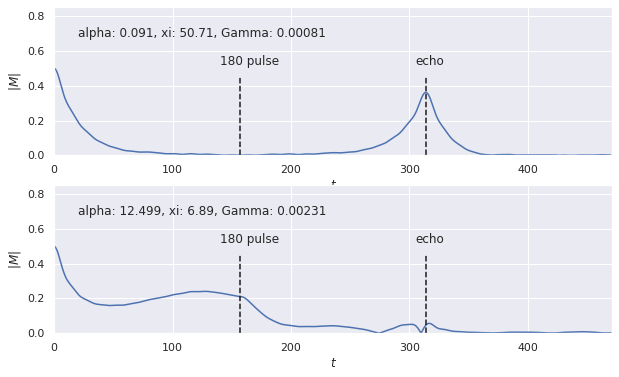

In [3]:
# view the data with three plots, two with a specific curve and one with a lot of curves
fig1, ax1 = plt.subplots(2,1, figsize=(10,6));

plot_idx1 = 228; # change this to see different curves
plot_idx2 = 0; # change this to see different curves

# string format for material parameter plotting
mat_format = "alpha: %.3f, xi: %.2f, Gamma: %.5f";

# view the selected curve, with a label of the material data
ax1[0].plot(abs(M[plot_idx1,:]));
ax1[0].text(20,0.68, mat_format % tuple(mat_info[plot_idx1,:]) );
ax1[0].plot([0, 0],[0, .45],'--k')
ax1[0].plot([157, 157],[0, .45],'--k')
ax1[0].text(140,0.52,"180 pulse")
ax1[0].text(305,0.52,"echo")
ax1[0].plot([2*157, 2*157],[0, .45],'--k')
ax1[0].axis([0, 471, 0, 0.85])
ax1[0].set(ylabel="$|M|$", xlabel="$t$");

# view the selected curve, with a label of the material data
ax1[1].plot(abs(M[plot_idx2,:]));
ax1[1].text(20,0.68, mat_format % tuple(mat_info[plot_idx2,:]) );
ax1[1].plot([0, 0],[0, .45],'--k')
ax1[1].plot([157, 157],[0, .45],'--k')
ax1[1].text(140,0.52,"180 pulse")
ax1[1].text(305,0.52,"echo")
ax1[1].plot([2*157, 2*157],[0, .45],'--k')
ax1[1].axis([0, 471, 0, 0.85])
ax1[1].set(ylabel="$|M|$", xlabel="$t$");

# Evaluation Task 1:

Although the above example allows us to look at two pairs of curves, it would be very tedious to iterate through the entire dataset like this!
As a warmup, make a visualization of the first 500 M(t) curves of the dataset.
What features seem to be universal? Are there any outliers?


### First we look at a time series plot of the Magnetization curves

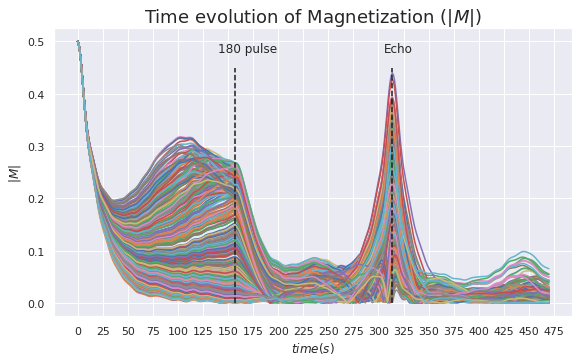

In [4]:
fig = plt.figure(figsize=(9,5))
ax = fig.add_axes([0.1,0.1,0.8,0.8])

# Here we plot 500 random M-curves
ncurves = 500 # change this to vary number of curves
for i in range(ncurves):
    ax.plot(np.abs(M[i*10,:]))
    
ax.plot([2*157, 2*157],[0, .45],'--k')
ax.plot([157, 157],[0, .45],'--k')
ax.text(140,0.48,"180 pulse")
ax.text(305,0.48,"Echo")
ax.set(ylabel="$|M|$", xlabel="$time (s)$");
ax.set_title("Time evolution of Magnetization ($|M|$)",fontsize=18)
ax.set_xticks(np.arange(0,476,25))
plt.show()

### Visualizing the distribuiton of |M| just before the 180 pulse and during the Echo

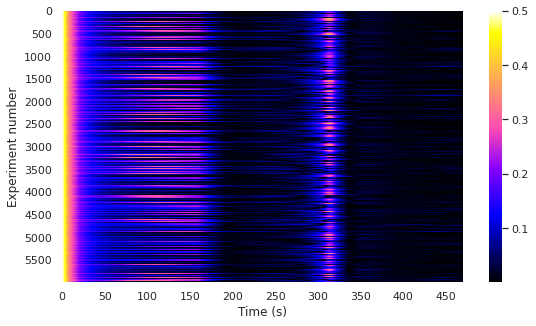

In [5]:
fig = plt.figure(figsize=(9,5))
sns.heatmap(np.abs(M),xticklabels=50,yticklabels=500,cmap='gnuplot2')
plt.xlabel('Time (s)')
plt.ylabel('Experiment number')
plt.show()

#### Few observations : 
- In the above heatmap, all curves start with a high initial |M| value and later drop until the 180 pulse that flips the spins
- Almost all the spins have low |M| values between timestamp: (180-300) until a peak that corresponds to the spin-echo and then again the magnetization decreases
- One can notice that the distribution of |M| during the 180 pulse and Spin echo phases differ by a large amount. On further inspection, we can learn more about the system by classfying the curve (high-low) if the distribution is bi-modal or look for outliers/exceptions using anomaly detection techniques 

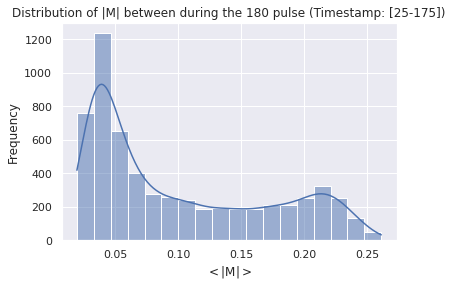

In [6]:
sns.histplot(np.mean(np.abs(M[:,25:175]),axis=1),kde=True)
plt.title('Distribution of |M| between during the 180 pulse (Timestamp: [25-175])')
plt.ylabel('Frequency')
plt.xlabel('$<$'+'|M|'+ '$>$')
plt.show()

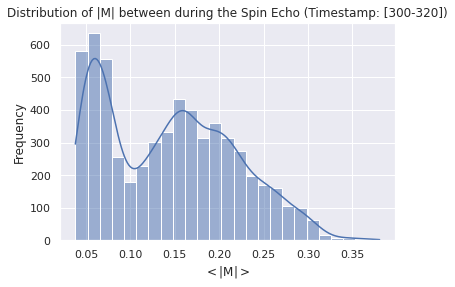

In [7]:
sns.histplot(np.mean(np.abs(M[:,300:320]),axis=1),kde=True)
plt.title('Distribution of |M| between during the Spin Echo (Timestamp: [300-320])')
plt.ylabel('Frequency')
plt.xlabel('$<$'+'|M|'+ '$>$')
plt.show()

Here, we observe a **bimodal distribution** for both |M| during the spin-echo phase and during the 180 pulse phase. 

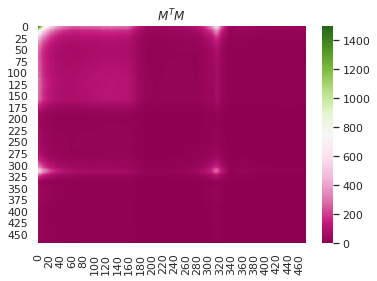

In [8]:
# Here, we simply plot a representative of the correlation between different times. 
sns.heatmap((np.abs(M).T @ np.abs(M)),cmap='PiYG',vmin=0, vmax=1500)
plt.title('$M^TM$')
plt.show()

- Here, one can observe that values at time:320 are correlated to the timestamps:[60,120]

# Evaluation Task 2:

Before building the model, first randomly partition the 6000 curves into a training set and a testing set.


In [9]:
 
# Partition data into a training and testing; use 30% for testing
# Here, we use the sklearn module

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(np.abs(M), mat_info, test_size=0.3, random_state=42)


# Evaluation Task 3:

Optimize a model using the training set to predict $\alpha$, $\xi$, and $\Gamma$ based on $M(t)$.

(Note: feel free to use any ML algorithim/model you want, from linear regression to a full neural net!)

In this notebook, we use the following ML models for regression: 
1. KNeighborsRegressor()
2. LinearRegression()
3. Ridge(alpha=1e-10)
4. Lasso(alpha=0.01, max_iter=10000.0)
5. ElasticNet()
6. RandomForestRegressor

In [10]:
# Preprocessing

from sklearn.preprocessing import MinMaxScaler #we use minmaxscaler because the data is not normally distributed
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor 
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet


In [11]:
def model_accuracy_scaled(mod):  #scale the features for linear models
    model_scaled = Pipeline([
        ('scale',MinMaxScaler()),
        ('model',mod)
    ])
    model_scaled.fit(X_train,y_train)
    return model_scaled.score(X_train,y_train), model_scaled.score(X_test,y_test)

def model_accuracy_unscaled(mod):  #unsclaed features for tree-based models
    model_unscaled = Pipeline([
        ('model',mod)
    ])
    model_unscaled.fit(X_train,y_train)
    return model_unscaled.score(X_train,y_train), model_unscaled.score(X_test,y_test)

In [12]:
linearmodels = [KNeighborsRegressor(), LinearRegression(), Ridge(alpha=1e-10), Lasso(alpha=1e-2,max_iter=1e4), ElasticNet()]
linearmodelnames = ['KNeighborsRegressor','LinearRegression','Ridge','Lasso','ElasticNet']

In [13]:
model_results={}
for i in range(len(linearmodels)):
    print(linearmodels[i])
    results = model_accuracy_scaled(linearmodels[i])
    print(f'Training accuracy:{results[0]:.3} ; Testing accuracy:{results[1]:.3} \n')
    model_results[linearmodelnames[i]] = results

KNeighborsRegressor()
Training accuracy:0.824 ; Testing accuracy:0.729 

LinearRegression()
Training accuracy:0.986 ; Testing accuracy:0.971 

Ridge(alpha=1e-10)
Training accuracy:0.986 ; Testing accuracy:0.971 

Lasso(alpha=0.01, max_iter=10000.0)
Training accuracy:0.234 ; Testing accuracy:0.222 

ElasticNet()
Training accuracy:-5.18e-16 ; Testing accuracy:-0.000582 



In [14]:
rdforest_result = model_accuracy_unscaled(RandomForestRegressor(random_state=0))
print('RandomForestRegressor()')
print(f'Training accuracy:{rdforest_result[0]:.3} ; Testing accuracy:{rdforest_result[1]:.3} \n)')
model_results['RandomForestRegressor'] = rdforest_result

RandomForestRegressor()
Training accuracy:0.982 ; Testing accuracy:0.861 
)


# Evaluation Task 4:
   
Validate the trained model on the testing partition of the dataset. Also visualize how your model's predicted values of $\alpha$, $\xi$, and $\Gamma$ compare to their true values from mat_info.txt.

In [15]:
print('Summary:\n')
print(model_results)

Summary:

{'KNeighborsRegressor': (0.8241567880663515, 0.7286973019515791), 'LinearRegression': (0.9856006922987124, 0.9708659347517351), 'Ridge': (0.9855995851207, 0.9708585204045628), 'Lasso': (0.23365575554699555, 0.22178471025555402), 'ElasticNet': (-5.181040781584064e-16, -0.0005823131984407463), 'RandomForestRegressor': (0.9815836036776692, 0.8613377067054454)}


<Figure size 1152x1080 with 0 Axes>

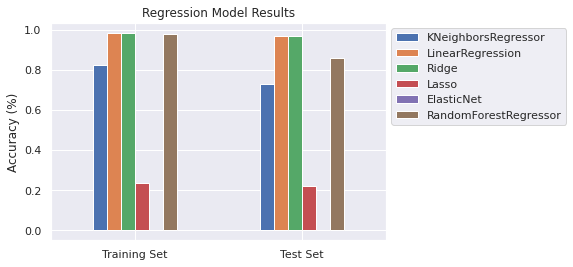

In [16]:
fig = plt.figure(figsize=(16,15))
pd.DataFrame(model_results).plot.bar() # use pandas to plot barchart
plt.title("Regression Model Results")
plt.xticks([0,1],['Training Set','Test Set'],rotation=0) # change xticks
plt.ylabel('Accuracy (%)')
plt.legend(bbox_to_anchor=[1.0,1.0])
plt.show()

### We look at the predictions of Linear regression

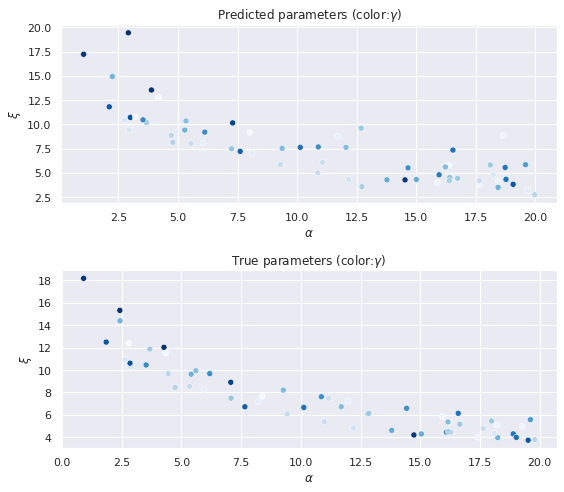

In [17]:
linreg = Pipeline([
        ('scale',MinMaxScaler()),
        ('model',LinearRegression())
    ])
linreg.fit(X_train,y_train)

pred = linreg.predict(X_test[::30,:])
true = y_test[::30]

fig,ax = plt.subplots(nrows=2,ncols=1,figsize=(8,7))
sns.scatterplot(x=pred[:,0],y=pred[:,1],c=pred[:,2],ax=ax[0],cmap='Blues')
sns.scatterplot(x=true[:,0],y=true[:,1],c=true[:,2],ax=ax[1],cmap='Blues')

for axes in ax:
    axes.set(xlabel='$\\alpha$',ylabel='$\\xi$')
ax[0].set_title('Predicted parameters (color:$\gamma$)')
ax[1].set_title('True parameters (color:$\gamma$)')

plt.tight_layout()
plt.show()

In [18]:
# We can look at some predictions 
linreg.predict((X_test[:10,:]))

array([[4.71672011e+00, 8.85646929e+00, 7.25746891e-04],
       [6.58149860e+00, 7.11401059e+00, 7.12025891e-04],
       [6.04726140e+00, 6.60196979e+00, 1.35431556e-03],
       [1.48205853e+01, 5.90240673e+00, 2.78544559e-04],
       [4.75913305e+00, 1.04976599e+01, 1.14328281e-03],
       [1.28069571e+01, 4.96177029e+00, 2.15149476e-03],
       [6.78774764e+00, 6.75293265e+00, 4.39999543e-04],
       [5.47574229e+00, 8.82751426e+00, 2.81260646e-04],
       [7.87515204e+00, 9.06733857e+00, 1.54206577e-04],
       [1.45481961e+01, 5.55132337e+00, 2.37232494e-03]])

In [19]:
# Example output of the Linear Regression model
# Select any example from the test dataset

example_no = 120  # change the value to test model predictions

pred_val, true_val = linreg.predict(X_test[example_no:example_no+1,:]), y_test[example_no]
print(f'Predicted parameters for test-example {example_no} from Linear regression: \n \t alpha = {pred_val[0,0]:.5}, xi = {pred_val[0,1]:.5}, gamma = {pred_val[0,2]:.5}')
print()
print(f'True parameters for test-example {example_no} from Linear regression: \n \t alpha = {true_val[0]:.5}, xi = {true_val[1]:.5}, gamma = {true_val[2]:.5}')

Predicted parameters for test-example 120 from Linear regression: 
 	 alpha = 18.734, xi = 5.5453, gamma = 0.0018213

True parameters for test-example 120 from Linear regression: 
 	 alpha = 18.89, xi = 4.2976, gamma = 0.001821


## Conclusions / Remarks : 

- Suprisingly, linear regression turns out to perform the best. 
- RandomForestRegressor seems to be overfitting. This can be reduced by pruning.
- Maybe, we can look at tuning the hyperparameters of Lasso and KNN regressors to improve their performance.
- Next, we will try to use a Neural netowrk to perform the same regression task. 

Thank you !